# Model 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Model function

In [ ]:
def simulate(A,B,C,initial_state,input_sequence, time_steps,sampling_period):
    from numpy.linalg import inv
    I=np.identity(A.shape[0]) # this is an identity matrix
    Ad=inv(I-sampling_period*A)
    Bd=Ad*sampling_period*B
    Xd=np.zeros(shape=(A.shape[0],time_steps+1))
    Yd=np.zeros(shape=(C.shape[0],time_steps+1))
    
    for i in range(0,time_steps):
       if i==0:
           Xd[:,[i]]=initial_state
           Yd[:,[i]]=C*initial_state
           x=Ad*initial_state+Bd*input_sequence[i]
       else:
           Xd[:,[i]]=x
           Yd[:,[i]]=C*x
           x=Ad*x+Bd*input_sequence[i]
    Xd[:,[-1]]=x
    Yd[:,[-1]]=C*x
    return Xd, Yd

## Example model output

Text(0.5, 1.0, 'System step response')

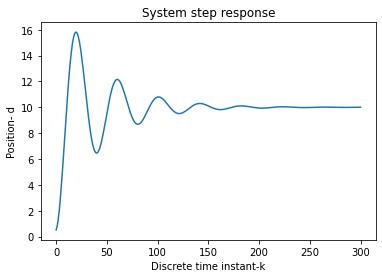

In [2]:
A = np.matrix([[0, 1], [- 0.1, -0.05]]) # state space A matrix
B = np.matrix([[0], [1]]) # state space B matrix
C = np.matrix([[1, 0]]) # state space C matrix

x0 = np.random.rand(2,1) # random init condition

time = 300 # time steps number
sampling = 0.5 # symulation time period

input_seq = np.ones(time) # define step input
plt.plot(input_sequence, label='u')

state,output = simulate(A, B, C, x0, input_seq, time ,sampling)    

plt.plot(output[0,:], label='y')
plt.xlabel('Discrete time instant-k')
plt.ylabel('Position- d')
plt.title('System step response')

## Definition of the identified model

In [3]:
A=np.matrix([[0, 1],[- 0.1, -0.000001]])
B=np.matrix([[0],[1]])
C=np.matrix([[1, 0]])

#define the number of time samples used for simulation and the discretization step (sampling)
time=200
sampling=0.5

# Model data
## Training data declaration

In [5]:
#define an input sequence for the simulation
input_seq_train=np.random.rand(time,1)
#define an initial state for simulation
x0_train=np.random.rand(2,1)


# here we simulate the dynamics
# from backward_euler import simulate
state,output_train=simulate(A,B,C,x0_train,input_seq_train, time ,sampling)    

output_train=output_train.T
# this is the output data used for training
output_train=np.reshape(output_train,(1,output_train.shape[0],1))

input_seq_train=np.reshape(input_seq_train,(input_seq_train.shape[0],1))
tmp_train=np.concatenate((input_seq_train, np.zeros(shape=(input_seq_train.shape[0],1))), axis=1)
tmp_train=np.concatenate((x0_train.T,tmp_train), axis=0)
# this is the input data used for training
trainX=np.reshape(tmp_train, (1,tmp_train.shape[0],tmp_train.shape[1]))

## Validation data declaration

In [ ]:
# new random input sequence
input_seq_validate=np.random.rand(time,1)
# new random initial condition
x0_validate=np.random.rand(2,1)

# create a new ouput sequence by simulating the system 
state_validate,output_validate=simulate(A,B,C,x0_validate,input_seq_validate, time ,sampling)    
output_validate=output_validate.T
# this is the output data used for validation
output_validate=np.reshape(output_validate,(1,output_validate.shape[0],1))

input_seq_validate=np.reshape(input_seq_validate,(input_seq_validate.shape[0],1))
tmp_validate=np.concatenate((input_seq_validate, np.zeros(shape=(input_seq_validate.shape[0],1))), axis=1)
tmp_validate=np.concatenate((x0_validate.T,tmp_validate), axis=0)
# this is the input data used for validation
validateX=np.reshape(tmp_validate, (1,tmp_validate.shape[0],tmp_validate.shape[1]))

## Test data declaration

In [ ]:
# new random input sequence
input_seq_test=np.random.rand(time,1)
# new random initial condition
x0_test=np.random.rand(2,1)

# create a new ouput sequence by simulating the system 
state_test,output_test=simulate(A,B,C,x0_test,input_seq_test, time ,sampling)    
output_test=output_test.T
# this is the output data used for test
output_test=np.reshape(output_test,(1,output_test.shape[0],1))

input_seq_test=np.reshape(input_seq_test,(input_seq_test.shape[0],1))
tmp_test=np.concatenate((input_seq_test, np.zeros(shape=(input_seq_test.shape[0],1))), axis=1)
tmp_test=np.concatenate((x0_test.T,tmp_test), axis=0)
# this is the input data used for test
testX=np.reshape(tmp_test, (1,tmp_test.shape[0],tmp_test.shape[1]))

# Model Train

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, SimpleRNN, TimeDistributed
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

model=Sequential()
#model.add(SimpleRNN(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
#model.add(GRU(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
#model.add(Dense(1))
model.add(TimeDistributed(Dense(1)))  #there is no difference between this and model.add(Dense(1))...
# does not make sense to use metrics=['acc'], see https://stackoverflow.com/questions/41819457/zero-accuracy-training-a-neural-network-in-keras
model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])


# after every epoch, we save the model
filepath='ss_rnn_model'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]
history=model.fit(trainX, output_train , epochs=2000, batch_size=1, callbacks=callbacks_list, validation_data=(validateX,output_validate), verbose=2)


# load the model with the smallest validation loss
#model.load_weights("weights-1997-1.878475.hdf5")

# use the test data to predict the model response
testPredict = model.predict(testX)

Epoch 1/2000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 31.3224 - mse: 31.3224 - val_loss: 31.9482 - val_mse: 31.9482
Epoch 2/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 30.3143 - mse: 30.3143 - val_loss: 31.0606 - val_mse: 31.0606
Epoch 3/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 29.5615 - mse: 29.5615 - val_loss: 30.2072 - val_mse: 30.2072
Epoch 4/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 28.8378 - mse: 28.8378 - val_loss: 29.3095 - val_mse: 29.3095
Epoch 5/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 28.0770 - mse: 28.0770 - val_loss: 28.3039 - val_mse: 28.3039
Epoch 6/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 27.2258 - mse: 27.2258 - val_loss: 27.1210 - val_mse: 27.1210
Epoch 7/2000
INFO:tensorflow:Assets w

1/1 - 3s - loss: 6.9759 - mse: 6.9759 - val_loss: 3.0297 - val_mse: 3.0297
Epoch 55/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 6.9674 - mse: 6.9674 - val_loss: 3.0214 - val_mse: 3.0214
Epoch 56/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 6.9594 - mse: 6.9594 - val_loss: 3.0136 - val_mse: 3.0136
Epoch 57/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 6.9518 - mse: 6.9518 - val_loss: 3.0062 - val_mse: 3.0062
Epoch 58/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 6.9448 - mse: 6.9448 - val_loss: 2.9994 - val_mse: 2.9994
Epoch 59/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 6.9382 - mse: 6.9382 - val_loss: 2.9930 - val_mse: 2.9930
Epoch 60/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 6.9320 - mse: 6.9320 - val_loss: 2.9870 - val_mse: 2.9870
Epoch 61/2000
INFO:tensorflow:Assets written to: ss_rnn_model

1/1 - 3s - loss: 6.8415 - mse: 6.8415 - val_loss: 2.8851 - val_mse: 2.8851
Epoch 112/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 6.8380 - mse: 6.8380 - val_loss: 2.9064 - val_mse: 2.9064
Epoch 113/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 6.8335 - mse: 6.8335 - val_loss: 2.8766 - val_mse: 2.8766
Epoch 114/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 6.8278 - mse: 6.8278 - val_loss: 2.9092 - val_mse: 2.9092
Epoch 115/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 6.8205 - mse: 6.8205 - val_loss: 2.8435 - val_mse: 2.8435
Epoch 116/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 6.8125 - mse: 6.8125 - val_loss: 2.9607 - val_mse: 2.9607
Epoch 117/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 6.8082 - mse: 6.8082 - val_loss: 2.7640 - val_mse: 2.7640
Epoch 118/2000
INFO:tensorflow:Assets written to: ss_rn

Epoch 168/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 5.2060 - mse: 5.2060 - val_loss: 2.0314 - val_mse: 2.0314
Epoch 169/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 5.0640 - mse: 5.0640 - val_loss: 1.8425 - val_mse: 1.8425
Epoch 170/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 5.5354 - mse: 5.5354 - val_loss: 2.0756 - val_mse: 2.0756
Epoch 171/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 5.4080 - mse: 5.4080 - val_loss: 1.9368 - val_mse: 1.9368
Epoch 172/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 5.0711 - mse: 5.0711 - val_loss: 1.7240 - val_mse: 1.7240
Epoch 173/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 5.1011 - mse: 5.1011 - val_loss: 2.2774 - val_mse: 2.2774
Epoch 174/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 5.3009 - mse: 5.3009 - val_loss: 2.1530 - v

Epoch 225/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 2.7743 - mse: 2.7743 - val_loss: 1.4371 - val_mse: 1.4371
Epoch 226/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 2.5988 - mse: 2.5988 - val_loss: 2.6488 - val_mse: 2.6488
Epoch 227/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 2.3824 - mse: 2.3824 - val_loss: 1.5069 - val_mse: 1.5069
Epoch 228/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 2.2306 - mse: 2.2306 - val_loss: 2.8534 - val_mse: 2.8534
Epoch 229/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 2.2632 - mse: 2.2632 - val_loss: 1.5493 - val_mse: 1.5493
Epoch 230/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 2.4520 - mse: 2.4520 - val_loss: 3.0425 - val_mse: 3.0425
Epoch 231/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 2.5653 - mse: 2.5653 - val_loss: 1.4965 - v

Epoch 282/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.2133 - mse: 1.2133 - val_loss: 2.7986 - val_mse: 2.7986
Epoch 283/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.4985 - mse: 1.4985 - val_loss: 1.6421 - val_mse: 1.6421
Epoch 284/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.9154 - mse: 1.9154 - val_loss: 1.7568 - val_mse: 1.7568
Epoch 285/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 2.1199 - mse: 2.1199 - val_loss: 0.8039 - val_mse: 0.8039
Epoch 286/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.6733 - mse: 1.6733 - val_loss: 2.8165 - val_mse: 2.8165
Epoch 287/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.0372 - mse: 1.0372 - val_loss: 2.0073 - val_mse: 2.0073
Epoch 288/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.1599 - mse: 1.1599 - val_loss: 3.0756 - v

Epoch 339/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.7876 - mse: 0.7876 - val_loss: 1.1964 - val_mse: 1.1964
Epoch 340/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.9902 - mse: 0.9902 - val_loss: 1.1778 - val_mse: 1.1778
Epoch 341/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.2449 - mse: 1.2449 - val_loss: 0.7321 - val_mse: 0.7321
Epoch 342/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.1080 - mse: 1.1080 - val_loss: 2.6033 - val_mse: 2.6033
Epoch 343/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.7780 - mse: 0.7780 - val_loss: 1.5392 - val_mse: 1.5392
Epoch 344/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.8881 - mse: 0.8881 - val_loss: 1.1801 - val_mse: 1.1801
Epoch 345/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.4229 - mse: 1.4229 - val_loss: 0.7128 - v

Epoch 396/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3646 - mse: 0.3646 - val_loss: 2.2251 - val_mse: 2.2251
Epoch 397/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.7507 - mse: 0.7507 - val_loss: 1.2259 - val_mse: 1.2259
Epoch 398/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.7201 - mse: 1.7201 - val_loss: 0.3347 - val_mse: 0.3347
Epoch 399/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.9888 - mse: 0.9888 - val_loss: 1.2979 - val_mse: 1.2979
Epoch 400/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2402 - mse: 0.2402 - val_loss: 1.3604 - val_mse: 1.3604
Epoch 401/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2725 - mse: 0.2725 - val_loss: 0.9793 - val_mse: 0.9793
Epoch 402/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3810 - mse: 0.3810 - val_loss: 1.2095 - v

Epoch 453/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.5388 - mse: 0.5388 - val_loss: 1.1879 - val_mse: 1.1879
Epoch 454/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.8537 - mse: 0.8537 - val_loss: 0.8962 - val_mse: 0.8962
Epoch 455/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.7352 - mse: 1.7352 - val_loss: 2.9536 - val_mse: 2.9536
Epoch 456/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.2086 - mse: 1.2086 - val_loss: 2.4872 - val_mse: 2.4872
Epoch 457/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.9130 - mse: 1.9130 - val_loss: 0.7204 - val_mse: 0.7204
Epoch 458/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.6174 - mse: 1.6174 - val_loss: 0.3677 - val_mse: 0.3677
Epoch 459/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.5679 - mse: 0.5679 - val_loss: 0.1975 - v

Epoch 510/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.5699 - mse: 0.5699 - val_loss: 0.3474 - val_mse: 0.3474
Epoch 511/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3840 - mse: 0.3840 - val_loss: 0.2725 - val_mse: 0.2725
Epoch 512/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3570 - mse: 0.3570 - val_loss: 0.4282 - val_mse: 0.4282
Epoch 513/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3893 - mse: 0.3893 - val_loss: 0.1903 - val_mse: 0.1903
Epoch 514/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.4864 - mse: 0.4864 - val_loss: 0.2431 - val_mse: 0.2431
Epoch 515/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.4629 - mse: 0.4629 - val_loss: 2.3305 - val_mse: 2.3305
Epoch 516/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.1738 - mse: 1.1738 - val_loss: 0.7130 - v

Epoch 567/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.4330 - mse: 0.4330 - val_loss: 0.7863 - val_mse: 0.7863
Epoch 568/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.1952 - mse: 1.1952 - val_loss: 3.1449 - val_mse: 3.1449
Epoch 569/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.6511 - mse: 1.6511 - val_loss: 2.0936 - val_mse: 2.0936
Epoch 570/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 2.4848 - mse: 2.4848 - val_loss: 0.8592 - val_mse: 0.8592
Epoch 571/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 2.2180 - mse: 2.2180 - val_loss: 0.2874 - val_mse: 0.2874
Epoch 572/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.7982 - mse: 0.7982 - val_loss: 0.1128 - val_mse: 0.1128
Epoch 573/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2567 - mse: 0.2567 - val_loss: 0.3282 - v

Epoch 624/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0690 - mse: 0.0690 - val_loss: 0.5335 - val_mse: 0.5335
Epoch 625/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0676 - mse: 0.0676 - val_loss: 0.4996 - val_mse: 0.4996
Epoch 626/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0665 - mse: 0.0665 - val_loss: 0.5186 - val_mse: 0.5186
Epoch 627/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0656 - mse: 0.0656 - val_loss: 0.4815 - val_mse: 0.4815
Epoch 628/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0649 - mse: 0.0649 - val_loss: 0.5109 - val_mse: 0.5109
Epoch 629/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0644 - mse: 0.0644 - val_loss: 0.4541 - val_mse: 0.4541
Epoch 630/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0646 - mse: 0.0646 - val_loss: 0.5202 - v

Epoch 681/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0481 - mse: 0.0481 - val_loss: 0.3017 - val_mse: 0.3017
Epoch 682/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0474 - mse: 0.0474 - val_loss: 0.2944 - val_mse: 0.2944
Epoch 683/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0471 - mse: 0.0471 - val_loss: 0.3028 - val_mse: 0.3028
Epoch 684/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0496 - mse: 0.0496 - val_loss: 0.2809 - val_mse: 0.2809
Epoch 685/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0743 - mse: 0.0743 - val_loss: 0.4288 - val_mse: 0.4288
Epoch 686/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2810 - mse: 0.2810 - val_loss: 0.9614 - val_mse: 0.9614
Epoch 687/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.4764 - mse: 1.4764 - val_loss: 2.1514 - v

Epoch 738/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2403 - mse: 0.2403 - val_loss: 0.3055 - val_mse: 0.3055
Epoch 739/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2558 - mse: 0.2558 - val_loss: 0.7365 - val_mse: 0.7365
Epoch 740/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1984 - mse: 0.1984 - val_loss: 0.2731 - val_mse: 0.2731
Epoch 741/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1525 - mse: 0.1525 - val_loss: 0.6371 - val_mse: 0.6371
Epoch 742/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1273 - mse: 0.1273 - val_loss: 0.2525 - val_mse: 0.2525
Epoch 743/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1101 - mse: 0.1101 - val_loss: 0.6424 - val_mse: 0.6424
Epoch 744/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1067 - mse: 0.1067 - val_loss: 0.2512 - v

Epoch 795/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1780 - mse: 0.1780 - val_loss: 0.5983 - val_mse: 0.5983
Epoch 796/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2026 - mse: 0.2026 - val_loss: 0.3343 - val_mse: 0.3343
Epoch 797/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3076 - mse: 0.3076 - val_loss: 0.6752 - val_mse: 0.6752
Epoch 798/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2224 - mse: 0.2224 - val_loss: 0.3262 - val_mse: 0.3262
Epoch 799/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1922 - mse: 0.1922 - val_loss: 0.5935 - val_mse: 0.5935
Epoch 800/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1482 - mse: 0.1482 - val_loss: 0.3036 - val_mse: 0.3036
Epoch 801/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1108 - mse: 0.1108 - val_loss: 0.5921 - v

Epoch 852/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0407 - mse: 0.0407 - val_loss: 0.3168 - val_mse: 0.3168
Epoch 853/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0453 - mse: 0.0453 - val_loss: 0.4003 - val_mse: 0.4003
Epoch 854/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0551 - mse: 0.0551 - val_loss: 0.3297 - val_mse: 0.3297
Epoch 855/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0898 - mse: 0.0898 - val_loss: 0.4972 - val_mse: 0.4972
Epoch 856/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1433 - mse: 0.1433 - val_loss: 0.5096 - val_mse: 0.5096
Epoch 857/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3279 - mse: 0.3279 - val_loss: 0.6822 - val_mse: 0.6822
Epoch 858/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3298 - mse: 0.3298 - val_loss: 0.7854 - v

Epoch 909/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0837 - mse: 0.0837 - val_loss: 0.4679 - val_mse: 0.4679
Epoch 910/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0670 - mse: 0.0670 - val_loss: 0.3836 - val_mse: 0.3836
Epoch 911/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0970 - mse: 0.0970 - val_loss: 0.6021 - val_mse: 0.6021
Epoch 912/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1459 - mse: 0.1459 - val_loss: 0.5683 - val_mse: 0.5683
Epoch 913/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3576 - mse: 0.3576 - val_loss: 1.1787 - val_mse: 1.1787
Epoch 914/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.6187 - mse: 0.6187 - val_loss: 1.0025 - val_mse: 1.0025
Epoch 915/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.7932 - mse: 0.7932 - val_loss: 0.5338 - v

Epoch 966/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0888 - mse: 0.0888 - val_loss: 0.2972 - val_mse: 0.2972
Epoch 967/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1126 - mse: 0.1126 - val_loss: 0.6603 - val_mse: 0.6603
Epoch 968/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1442 - mse: 0.1442 - val_loss: 0.3553 - val_mse: 0.3553
Epoch 969/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3233 - mse: 0.3233 - val_loss: 0.5703 - val_mse: 0.5703
Epoch 970/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.6649 - mse: 0.6649 - val_loss: 2.4301 - val_mse: 2.4301
Epoch 971/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.1189 - mse: 1.1189 - val_loss: 2.1597 - val_mse: 2.1597
Epoch 972/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 1.1623 - mse: 1.1623 - val_loss: 0.3528 - v

1/1 - 3s - loss: 0.0795 - mse: 0.0795 - val_loss: 0.3479 - val_mse: 0.3479
Epoch 1023/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1368 - mse: 0.1368 - val_loss: 0.5059 - val_mse: 0.5059
Epoch 1024/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1160 - mse: 0.1160 - val_loss: 0.3629 - val_mse: 0.3629
Epoch 1025/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1782 - mse: 0.1782 - val_loss: 0.4351 - val_mse: 0.4351
Epoch 1026/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1071 - mse: 0.1071 - val_loss: 0.3952 - val_mse: 0.3952
Epoch 1027/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1406 - mse: 0.1406 - val_loss: 0.4874 - val_mse: 0.4874
Epoch 1028/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2467 - mse: 0.2467 - val_loss: 1.3028 - val_mse: 1.3028
Epoch 1029/2000
INFO:tensorflow:Assets written to

Epoch 1079/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0927 - mse: 0.0927 - val_loss: 0.4425 - val_mse: 0.4425
Epoch 1080/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1242 - mse: 0.1242 - val_loss: 0.5245 - val_mse: 0.5245
Epoch 1081/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1258 - mse: 0.1258 - val_loss: 0.4671 - val_mse: 0.4671
Epoch 1082/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1574 - mse: 0.1574 - val_loss: 0.5389 - val_mse: 0.5389
Epoch 1083/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1178 - mse: 0.1178 - val_loss: 0.4761 - val_mse: 0.4761
Epoch 1084/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1307 - mse: 0.1307 - val_loss: 0.5472 - val_mse: 0.5472
Epoch 1085/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0966 - mse: 0.0966 - val_loss: 0.5

1/1 - 3s - loss: 0.1653 - mse: 0.1653 - val_loss: 0.5818 - val_mse: 0.5818
Epoch 1136/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1163 - mse: 0.1163 - val_loss: 0.5184 - val_mse: 0.5184
Epoch 1137/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0519 - mse: 0.0519 - val_loss: 0.5784 - val_mse: 0.5784
Epoch 1138/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0741 - mse: 0.0741 - val_loss: 0.5339 - val_mse: 0.5339
Epoch 1139/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1461 - mse: 0.1461 - val_loss: 0.8345 - val_mse: 0.8345
Epoch 1140/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3516 - mse: 0.3516 - val_loss: 0.9233 - val_mse: 0.9233
Epoch 1141/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.6432 - mse: 0.6432 - val_loss: 1.0393 - val_mse: 1.0393
Epoch 1142/2000
INFO:tensorflow:Assets written to

Epoch 1192/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2747 - mse: 0.2747 - val_loss: 0.5131 - val_mse: 0.5131
Epoch 1193/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0732 - mse: 0.0732 - val_loss: 0.4732 - val_mse: 0.4732
Epoch 1194/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0648 - mse: 0.0648 - val_loss: 0.5872 - val_mse: 0.5872
Epoch 1195/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0735 - mse: 0.0735 - val_loss: 0.5502 - val_mse: 0.5502
Epoch 1196/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1904 - mse: 0.1904 - val_loss: 0.9451 - val_mse: 0.9451
Epoch 1197/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.5429 - mse: 0.5429 - val_loss: 1.4215 - val_mse: 1.4215
Epoch 1198/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.7660 - mse: 0.7660 - val_loss: 1.4

1/1 - 3s - loss: 0.1265 - mse: 0.1265 - val_loss: 0.6679 - val_mse: 0.6679
Epoch 1249/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1898 - mse: 0.1898 - val_loss: 0.6190 - val_mse: 0.6190
Epoch 1250/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3490 - mse: 0.3490 - val_loss: 0.8872 - val_mse: 0.8872
Epoch 1251/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.4434 - mse: 0.4434 - val_loss: 1.0179 - val_mse: 1.0179
Epoch 1252/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3445 - mse: 0.3445 - val_loss: 0.9840 - val_mse: 0.9840
Epoch 1253/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3458 - mse: 0.3458 - val_loss: 0.5375 - val_mse: 0.5375
Epoch 1254/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1069 - mse: 0.1069 - val_loss: 0.5644 - val_mse: 0.5644
Epoch 1255/2000
INFO:tensorflow:Assets written to

Epoch 1305/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.4783 - mse: 0.4783 - val_loss: 0.7037 - val_mse: 0.7037
Epoch 1306/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1436 - mse: 0.1436 - val_loss: 0.4233 - val_mse: 0.4233
Epoch 1307/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1280 - mse: 0.1280 - val_loss: 0.8147 - val_mse: 0.8147
Epoch 1308/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1189 - mse: 0.1189 - val_loss: 0.4661 - val_mse: 0.4661
Epoch 1309/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1240 - mse: 0.1240 - val_loss: 0.5056 - val_mse: 0.5056
Epoch 1310/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0594 - mse: 0.0594 - val_loss: 0.4924 - val_mse: 0.4924
Epoch 1311/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0558 - mse: 0.0558 - val_loss: 0.5

1/1 - 3s - loss: 0.0915 - mse: 0.0915 - val_loss: 0.4931 - val_mse: 0.4931
Epoch 1362/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2028 - mse: 0.2028 - val_loss: 0.7844 - val_mse: 0.7844
Epoch 1363/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1340 - mse: 0.1340 - val_loss: 0.5269 - val_mse: 0.5269
Epoch 1364/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1445 - mse: 0.1445 - val_loss: 0.5046 - val_mse: 0.5046
Epoch 1365/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1277 - mse: 0.1277 - val_loss: 0.6283 - val_mse: 0.6283
Epoch 1366/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1204 - mse: 0.1204 - val_loss: 0.5071 - val_mse: 0.5071
Epoch 1367/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1370 - mse: 0.1370 - val_loss: 0.6219 - val_mse: 0.6219
Epoch 1368/2000
INFO:tensorflow:Assets written to

Epoch 1418/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0603 - mse: 0.0603 - val_loss: 0.6003 - val_mse: 0.6003
Epoch 1419/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0542 - mse: 0.0542 - val_loss: 0.5077 - val_mse: 0.5077
Epoch 1420/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0788 - mse: 0.0788 - val_loss: 0.6911 - val_mse: 0.6911
Epoch 1421/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1009 - mse: 0.1009 - val_loss: 0.5790 - val_mse: 0.5790
Epoch 1422/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1738 - mse: 0.1738 - val_loss: 0.7358 - val_mse: 0.7358
Epoch 1423/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3481 - mse: 0.3481 - val_loss: 1.4741 - val_mse: 1.4741
Epoch 1424/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.4567 - mse: 0.4567 - val_loss: 1.1

1/1 - 3s - loss: 0.0756 - mse: 0.0756 - val_loss: 0.6640 - val_mse: 0.6640
Epoch 1475/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0735 - mse: 0.0735 - val_loss: 0.6295 - val_mse: 0.6295
Epoch 1476/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0711 - mse: 0.0711 - val_loss: 0.6398 - val_mse: 0.6398
Epoch 1477/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0766 - mse: 0.0766 - val_loss: 0.6667 - val_mse: 0.6667
Epoch 1478/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1173 - mse: 0.1173 - val_loss: 0.6846 - val_mse: 0.6846
Epoch 1479/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2458 - mse: 0.2458 - val_loss: 0.9435 - val_mse: 0.9435
Epoch 1480/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.7029 - mse: 0.7029 - val_loss: 1.4905 - val_mse: 1.4905
Epoch 1481/2000
INFO:tensorflow:Assets written to

Epoch 1531/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1924 - mse: 0.1924 - val_loss: 0.9068 - val_mse: 0.9068
Epoch 1532/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2321 - mse: 0.2321 - val_loss: 0.6651 - val_mse: 0.6651
Epoch 1533/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2723 - mse: 0.2723 - val_loss: 0.8576 - val_mse: 0.8576
Epoch 1534/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1865 - mse: 0.1865 - val_loss: 0.6065 - val_mse: 0.6065
Epoch 1535/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1309 - mse: 0.1309 - val_loss: 0.7015 - val_mse: 0.7015
Epoch 1536/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0814 - mse: 0.0814 - val_loss: 0.5490 - val_mse: 0.5490
Epoch 1537/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0616 - mse: 0.0616 - val_loss: 0.6

1/1 - 3s - loss: 0.0949 - mse: 0.0949 - val_loss: 0.6099 - val_mse: 0.6099
Epoch 1588/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1218 - mse: 0.1218 - val_loss: 0.6449 - val_mse: 0.6449
Epoch 1589/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0958 - mse: 0.0958 - val_loss: 0.7308 - val_mse: 0.7308
Epoch 1590/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0952 - mse: 0.0952 - val_loss: 0.6359 - val_mse: 0.6359
Epoch 1591/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1246 - mse: 0.1246 - val_loss: 0.9066 - val_mse: 0.9066
Epoch 1592/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 4s - loss: 0.1501 - mse: 0.1501 - val_loss: 0.8446 - val_mse: 0.8446
Epoch 1593/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3936 - mse: 0.3936 - val_loss: 1.3065 - val_mse: 1.3065
Epoch 1594/2000
INFO:tensorflow:Assets written to

Epoch 1644/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0664 - mse: 0.0664 - val_loss: 0.5396 - val_mse: 0.5396
Epoch 1645/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1063 - mse: 0.1063 - val_loss: 0.6180 - val_mse: 0.6180
Epoch 1646/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0983 - mse: 0.0983 - val_loss: 0.6269 - val_mse: 0.6269
Epoch 1647/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1397 - mse: 0.1397 - val_loss: 0.5691 - val_mse: 0.5691
Epoch 1648/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0999 - mse: 0.0999 - val_loss: 0.6963 - val_mse: 0.6963
Epoch 1649/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1092 - mse: 0.1092 - val_loss: 0.5120 - val_mse: 0.5120
Epoch 1650/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1073 - mse: 0.1073 - val_loss: 0.6

1/1 - 3s - loss: 0.0364 - mse: 0.0364 - val_loss: 0.5986 - val_mse: 0.5986
Epoch 1701/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0442 - mse: 0.0442 - val_loss: 0.6620 - val_mse: 0.6620
Epoch 1702/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0477 - mse: 0.0477 - val_loss: 0.6294 - val_mse: 0.6294
Epoch 1703/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0674 - mse: 0.0674 - val_loss: 0.6715 - val_mse: 0.6715
Epoch 1704/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0812 - mse: 0.0812 - val_loss: 0.6816 - val_mse: 0.6816
Epoch 1705/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1134 - mse: 0.1134 - val_loss: 0.6567 - val_mse: 0.6567
Epoch 1706/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1244 - mse: 0.1244 - val_loss: 0.7024 - val_mse: 0.7024
Epoch 1707/2000
INFO:tensorflow:Assets written to

Epoch 1757/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0498 - mse: 0.0498 - val_loss: 0.7550 - val_mse: 0.7550
Epoch 1758/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0311 - mse: 0.0311 - val_loss: 0.6523 - val_mse: 0.6523
Epoch 1759/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0290 - mse: 0.0290 - val_loss: 0.7357 - val_mse: 0.7357
Epoch 1760/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0351 - mse: 0.0351 - val_loss: 0.6495 - val_mse: 0.6495
Epoch 1761/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0694 - mse: 0.0694 - val_loss: 0.8619 - val_mse: 0.8619
Epoch 1762/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1231 - mse: 0.1231 - val_loss: 0.8397 - val_mse: 0.8397
Epoch 1763/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3130 - mse: 0.3130 - val_loss: 1.4

1/1 - 3s - loss: 0.0466 - mse: 0.0466 - val_loss: 0.7212 - val_mse: 0.7212
Epoch 1814/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0371 - mse: 0.0371 - val_loss: 0.7266 - val_mse: 0.7266
Epoch 1815/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0337 - mse: 0.0337 - val_loss: 0.6970 - val_mse: 0.6970
Epoch 1816/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0362 - mse: 0.0362 - val_loss: 0.8107 - val_mse: 0.8107
Epoch 1817/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0566 - mse: 0.0566 - val_loss: 0.6053 - val_mse: 0.6053
Epoch 1818/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1315 - mse: 0.1315 - val_loss: 1.1248 - val_mse: 1.1248
Epoch 1819/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3201 - mse: 0.3201 - val_loss: 0.9372 - val_mse: 0.9372
Epoch 1820/2000
INFO:tensorflow:Assets written to

Epoch 1870/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1027 - mse: 0.1027 - val_loss: 0.7407 - val_mse: 0.7407
Epoch 1871/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0778 - mse: 0.0778 - val_loss: 0.7910 - val_mse: 0.7910
Epoch 1872/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0610 - mse: 0.0610 - val_loss: 0.7657 - val_mse: 0.7657
Epoch 1873/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0459 - mse: 0.0459 - val_loss: 0.7613 - val_mse: 0.7613
Epoch 1874/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0404 - mse: 0.0404 - val_loss: 0.8158 - val_mse: 0.8158
Epoch 1875/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0484 - mse: 0.0484 - val_loss: 0.6942 - val_mse: 0.6942
Epoch 1876/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1094 - mse: 0.1094 - val_loss: 0.9

1/1 - 3s - loss: 0.1111 - mse: 0.1111 - val_loss: 0.7913 - val_mse: 0.7913
Epoch 1927/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0931 - mse: 0.0931 - val_loss: 0.7245 - val_mse: 0.7245
Epoch 1928/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0762 - mse: 0.0762 - val_loss: 0.9000 - val_mse: 0.9000
Epoch 1929/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.0891 - mse: 0.0891 - val_loss: 0.5799 - val_mse: 0.5799
Epoch 1930/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1501 - mse: 0.1501 - val_loss: 1.0570 - val_mse: 1.0570
Epoch 1931/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2147 - mse: 0.2147 - val_loss: 0.8467 - val_mse: 0.8467
Epoch 1932/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.3811 - mse: 0.3811 - val_loss: 0.9881 - val_mse: 0.9881
Epoch 1933/2000
INFO:tensorflow:Assets written to

Epoch 1983/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1226 - mse: 0.1226 - val_loss: 0.6911 - val_mse: 0.6911
Epoch 1984/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1557 - mse: 0.1557 - val_loss: 0.7926 - val_mse: 0.7926
Epoch 1985/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2102 - mse: 0.2102 - val_loss: 0.6487 - val_mse: 0.6487
Epoch 1986/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2918 - mse: 0.2918 - val_loss: 1.5324 - val_mse: 1.5324
Epoch 1987/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2020 - mse: 0.2020 - val_loss: 0.9462 - val_mse: 0.9462
Epoch 1988/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.1473 - mse: 0.1473 - val_loss: 0.7084 - val_mse: 0.7084
Epoch 1989/2000
INFO:tensorflow:Assets written to: ss_rnn_model/assets
1/1 - 3s - loss: 0.2229 - mse: 0.2229 - val_loss: 0.9

# Ploting result data

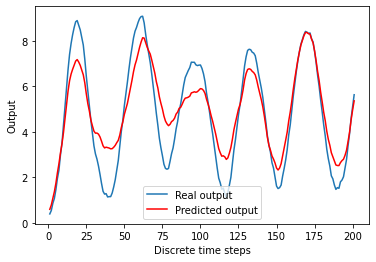

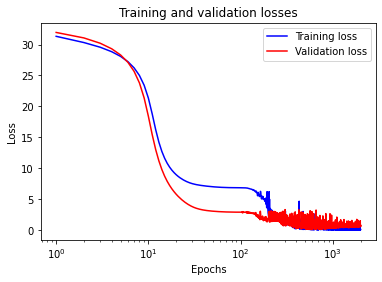

In [9]:
# plot the predicted and the "true" (test) outputs
time_plot=range(1,time+2)
plt.figure()
plt.plot(time_plot,testPredict[0,:,0], label='Real output')
plt.plot(time_plot,output_test[0,:],'r', label='Predicted output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()

loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs, loss,'b', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
plt.legend()